In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.opto_utils import opto_metrics, load_opto_sig
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil 
import seaborn as sns
import math
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
from joblib import Parallel, delayed
%matplotlib inline

In [2]:
# Make combined session-unit table
dfs = [pd.read_csv('/root/capsule/code/data_management/session_assets.csv'),
        pd.read_csv('/root/capsule/code/data_management/hopkins_session_assets.csv')]
df = pd.concat(dfs)
exclude = ['ecephys_717120_2024-03-06_12-23-53', 'ecephys_713854_2024-03-08_14-54-25', 'ecephys_713854_2024-03-08_16-20-33', 'behavior_754897_2025-03-15_11-32-18']
# session_ids, behs = zip(*[
#     (session, beh)
#     for session, beh in zip(session_ids, behs)
#     if isinstance(session, str) and session not in exclude
# ])
# exclude sessions
df = df[~df['session_id'].isin(exclude)]
# remove those are not strings
df = df[df['session_id'].apply(lambda x: isinstance(x, str))]
# session_ids = list(session_ids)
# behs = list(behs)

In [5]:
def process_session(session, beh, rec_side, probe, target='soma'):
    session_dir = session_dirs(session)
    bin_short = 100
    bin_long = 300
    # --- skip missing or invalid sessions ---
    if 'ZS' in session:
        if (not os.path.exists(session_dir['nwb_dir_raw'])) or (get_unit_tbl(session, 'curated') is None):
            print(f'Skipping {session} due to no neuron data')
            return None
    if session_dir['curated_dir_curated'] is None:
        return None

    print(f'Processing {session}')
    data_type = 'curated'
    qm_file = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
    with open(qm_file) as f:
        qm_dict = json.load(f)

    # --- load data ---
    unit_tbl = get_unit_tbl(session, data_type)
    if unit_tbl is None or len(unit_tbl) == 0:
        return None

    opto_metrics_session = opto_metrics(session, data_type=data_type)
    session_df = get_session_tbl(session)
    session_opto_sig = load_opto_sig(session, data_type=data_type)

    # --- basic derived columns ---
    if 'p_max' not in unit_tbl.columns:
        p_max = unit_tbl['p_max_x'].tolist()
        p_mean = unit_tbl['p_mean_x'].tolist()
        lat_max_p = unit_tbl['lat_max_p_x'].tolist()
        eu = unit_tbl['euc_max_p_x'].tolist()
        corr = unit_tbl['corr_max_p_x'].tolist()
        peaks = unit_tbl['peak_x'].values
        amp = unit_tbl['amp_x'].values
    else:
        p_max = unit_tbl['p_max'].tolist()
        p_mean = unit_tbl['p_mean'].tolist()
        lat_max_p = unit_tbl['lat_max_p'].tolist()
        eu = unit_tbl['euc_max_p'].tolist()
        corr = unit_tbl['corr_max_p'].tolist()
        peaks = unit_tbl['peak'].values
        amp = unit_tbl['amp'].values

    if 'x_ccf' in unit_tbl.columns:
        x_ccf = unit_tbl['x_ccf'].tolist()
        y_ccf = unit_tbl['y_ccf'].tolist()
        z_ccf = unit_tbl['z_ccf'].tolist()
    else:
        x_ccf = [np.nan]*len(unit_tbl)
        y_ccf = [np.nan]*len(unit_tbl)
        z_ccf = [np.nan]*len(unit_tbl)

    # --- waveform-related ---
    if 'peak_wf_opt' in unit_tbl.columns:
        wf_opt = [wf_opt_unit if isinstance(wf_opt_unit, np.ndarray) else wf_unit
                  for wf_opt_unit, wf_unit in zip(unit_tbl['peak_wf_opt'], unit_tbl['peak_wf'])]
        wf_opt_aligned = [wf_opt_unit if isinstance(wf_opt_unit, np.ndarray) else wf_unit
                          for wf_opt_unit, wf_unit in zip(unit_tbl['peak_wf_opt_aligned'], unit_tbl['peak_wf_aligned'])]
        wf_opt_2d = [wf_opt_unit if isinstance(wf_opt_unit, np.ndarray) else wf_unit
                     for wf_opt_unit, wf_unit in zip(unit_tbl['mat_wf_opt'], unit_tbl['wf_2d'])]
    else:
        wf_opt = unit_tbl['peak_wf'].tolist()
        wf_opt_aligned = unit_tbl['peak_wf_aligned'].tolist()
        wf_opt_2d = unit_tbl['wf_2d'].tolist()

    amp_opt = [
        np.max(wf_opt_curr) - np.min(wf_opt_curr) if isinstance(wf_opt_curr, np.ndarray) else curr_amp_unit
        for wf_opt_curr, curr_amp_unit in zip(wf_opt, amp)
    ]
    if 'amplitude_opt' in unit_tbl.columns:
        peak_opt = [
            curr_peak_opt if not np.isnan(curr_peak_opt) else curr_peak
            for curr_peak_opt, curr_peak in zip(unit_tbl['amplitude_opt'].values, peaks)
        ]
    else:
        peak_opt = list(peaks)

    if 'peak_waveform_raw_aligned' in unit_tbl.columns:
        wf_raw = unit_tbl['peak_waveform_raw_fake_aligned'].tolist()
        wf_2d_raw = unit_tbl['mat_wf_raw_fake'].tolist()
        peak_raw = [
            curr_peak_raw - curr_wf[0] if curr_peak_raw is not None and not np.isnan(curr_peak_raw)
            else None
            for curr_peak_raw, curr_wf in zip(unit_tbl['peak_raw_fake'], wf_raw)
        ]
        amp_raw = unit_tbl['amplitude_raw_fake'].tolist()
    else:
        wf_raw = [None]*len(unit_tbl)
        wf_2d_raw = [None]*len(unit_tbl)
        peak_raw = [None]*len(unit_tbl)
        amp_raw = [None]*len(unit_tbl)

    # --- waveform-independent scalar values ---
    isi_v = unit_tbl['isi_violations_ratio'].tolist()
    snr = unit_tbl['snr'].tolist()
    y_loc = unit_tbl['y_loc'].tolist()
    fr = unit_tbl['firing_rate'].tolist()
    decoder = unit_tbl['decoder_label'].tolist()
    tag_loc = unit_tbl['tagged_loc'].tolist() if 'tagged_loc' in unit_tbl.columns else [np.nan]*len(unit_tbl)
    top = unit_tbl['LC_range_top'].tolist() if 'LC_range_top' in unit_tbl.columns else [np.nan]*len(unit_tbl)
    bottom = unit_tbl['LC_range_bottom'].tolist() if 'LC_range_bottom' in unit_tbl.columns else [np.nan]*len(unit_tbl)

    # --- opto per-unit results ---
    resp_p_all_conditions, resp_lat_all_conditions = [], []
    mean_p_all_conditions, eu_all_conditions = [], []
    corr_all_conditions, sig_counts_all_conditions = [], []
    all_sig_counts = []
    trial_count = []
    sd_all = []
    len_all = []

    for unit_id in unit_tbl['unit_id'].values:
        start_time = qm_dict['ephys_cut'][0]
        end_time = qm_dict['ephys_cut'][1]
        spike_times = unit_tbl[unit_tbl['unit_id'] == unit_id]['spike_times'].values[0]
        unit_opto = opto_metrics_session.load_unit(unit_id)
        unit_opto_sig = session_opto_sig.load_unit(unit_id) if session_opto_sig is not None else None
        unit_drift = load_drift(session, unit_id, data_type=data_type)
        if unit_opto is None:
            continue

        curr_p_resp_all = unit_opto['resp_p_bl'].values
        curr_lat_resp_all = unit_opto['resp_lat'].values
        curr_p_mean_all = unit_opto['mean_p'].values
        curr_eu_all = unit_opto['euclidean_norm'].values
        curr_corr_all = unit_opto['correlation'].values

        unit_opto['sig_num'] = np.full(len(unit_opto), np.nan)
        if unit_opto_sig is not None:
            if not session_dir['aniID'].startswith('ZS'):
                for cond_ind, row in unit_opto.iterrows():
                    filt = (unit_opto_sig['power'] == row['powers']) & (unit_opto_sig['site'] == row['sites'])
                    if len(unit_opto_sig['pre_post'].unique()) > 1:
                        filt &= (unit_opto_sig['pre_post'] == row['stim_times'])
                    curr_sig_rows = unit_opto_sig[filt]
                    if len(curr_sig_rows) >= 1:
                        unit_opto.loc[cond_ind, 'sig_num'] = curr_sig_rows['p_sig_count'].values[0]
            else:
                unit_opto['sig_num'] = unit_opto_sig['p_sig_count'].values[0]

        curr_sig_num_all = unit_opto['sig_num'].values
        curr_max_count = np.nan if unit_opto_sig is None else unit_opto_sig['p_sig_count'].max()
        # cut off unstable
        spike_times_curr = spike_times
        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                start_time = max(start_time, unit_drift['ephys_cut'][0])
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                end_time = min(end_time, unit_drift['ephys_cut'][1])
        # trial length
        if session_df is not None:
            go_cue_times = session_df['goCue_start_time']
            if unit_drift is not None:
                if unit_drift['ephys_cut'][0] is not None:
                    go_cue_times = go_cue_times[go_cue_times >= unit_drift['ephys_cut'][0]]
                if unit_drift['ephys_cut'][1] is not None:
                    go_cue_times = go_cue_times[go_cue_times <= unit_drift['ephys_cut'][1]]
            curr_trial_count = len(go_cue_times)
        else:
            curr_trial_count = 0
        
        # append drift params if exist
        if unit_drift is not None:
            sd = unit_drift['sd/mean_updated']
        else:
            if end_time - start_time < bin_long*2:
                sd = np.nan
            else:
                temp_bins = np.arange(start_time, end_time, bin_short)
                spike_counts_slow = np.full(len(temp_bins)-1, np.nan)
                for i in range(len(temp_bins)-1):
                    bin_mask = (spike_times_curr >= temp_bins[i]-0.5*bin_long) & (spike_times_curr < temp_bins[i+1] + 0.5*bin_long)
                    spike_counts_slow[i] = np.sum(bin_mask)/bin_long
                sd = np.std(spike_counts_slow[np.where(~np.isnan(spike_counts_slow))[0]])/np.nanmean(spike_counts_slow)


        len_all.append(end_time-start_time)
        sd_all.append(sd)
        resp_p_all_conditions.append(curr_p_resp_all)
        resp_lat_all_conditions.append(curr_lat_resp_all)
        mean_p_all_conditions.append(curr_p_mean_all)
        eu_all_conditions.append(curr_eu_all)
        corr_all_conditions.append(curr_corr_all)
        sig_counts_all_conditions.append(curr_sig_num_all)
        all_sig_counts.append(curr_max_count)
        trial_count.append(curr_trial_count)

    # --- final dictionary ---
    return {
        'session': session,
        'unit': unit_tbl['unit_id'].tolist(),
        'qc_pass': unit_tbl['default_qc'].tolist(),
        'opto_tagged': unit_tbl['tagged_loc'].tolist(),


        
        'in_df': beh,
        'trial_count': trial_count,
        'p_max': p_max,
        'p_mean': p_mean,
        'sig_counts': all_sig_counts,
        'lat_max_p': lat_max_p,
        'isi_violations': isi_v,
        'snr': snr,
        'eu': eu,
        'corr': corr,
        'amp': amp_opt,
        'amp_raw': amp_raw,
        'peak': peak_opt,
        'peak_raw': peak_raw,
        'wf': wf_opt,
        'wf_raw': wf_raw,
        'wf_aligned': wf_opt_aligned,
        'wf_2d': wf_opt_2d,
        'wf_2d_raw': wf_2d_raw,
        'probe': probe,
        'y_loc': y_loc,
        'rec_side': rec_side,
        'top': top,
        'bottom': bottom,
        'tag_loc': tag_loc,
        'fr': fr,
        'decoder': decoder,
        'all_p_max': resp_p_all_conditions,
        'all_p_mean': mean_p_all_conditions,
        'all_lat_max_p': resp_lat_all_conditions,
        'all_corr': corr_all_conditions,
        'all_eu': eu_all_conditions,
        'all_sig_counts': sig_counts_all_conditions,
        'x_ccf': x_ccf,
        'y_ccf': y_ccf,
        'z_ccf': z_ccf,
        'sd': sd_all,
        'rec_len': len_all,
    }


In [6]:
target = 'soma'
def safe_process(session, beh, rec_side, probe):
    # try:
    return process_session(session, beh, rec_side, probe, target=target)
    # except Exception as e:
    #     print(f'Error processing {session}: {e}')
    #     return None

# for index, row in df.iterrows():
#     result = safe_process(row['session_id'], row['behavior'], row['side'], row['probe'])
#     if result is not None:
#         results.append(result)
results = Parallel(n_jobs=12)(
    delayed(safe_process)(row['session_id'], row['behavior'], row['side'], row['probe'])
    for _, row in df.iterrows()
)


Processing ecephys_713854_2024-03-05_12-01-40
Processing ecephys_713854_2024-03-05_13-31-20
Processing ecephys_717120_2024-03-07_12-12-02
Processing ecephys_713854_2024-03-08_15-43-01
Processing ecephys_713854_2024-03-05_13-01-09
Processing ecephys_717120_2024-03-06_12-54-27
Processing ecephys_684930_2023-09-27_10-04-04
Processing ecephys_687697_2023-09-15_11-30-06
Processing ecephys_684930_2023-09-28_11-45-27
Processing ecephys_684930_2023-09-28_12-44-15
Processing ecephys_687697_2023-09-15_12-36-06
Processing ecephys_691893_2023-10-05_12-46-57
Processing behavior_716325_2024-05-31_10-31-14
Processing ecephys_691893_2023-10-06_13-48-18
Processing behavior_717121_2024-06-15_10-00-58


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing behavior_751004_2024-12-19_11-50-37
Processing behavior_751004_2024-12-20_13-26-11
Processing behavior_751004_2024-12-21_13-28-28
Processing behavior_751004_2024-12-22_13-09-17
Processing behavior_751004_2024-12-23_14-20-03
Processing behavior_751769_2025-01-16_11-32-05
Processing behavior_751769_2025-01-17_11-37-39
Processing behavior_758017_2025-02-04_11-57-38
Processing behavior_751769_2025-01-18_10-15-25
Processing behavior_758017_2025-02-05_11-42-34
Processing behavior_758017_2025-02-06_11-26-14
Processing behavior_758017_2025-02-07_14-11-08
Processing behavior_751766_2025-02-11_11-53-38
Processing behavior_751766_2025-02-13_11-31-21
Processing behavior_751766_2025-02-14_11-37-11
Processing behavior_751181_2025-02-25_12-12-35
Processing behavior_751181_2025-02-26_11-51-19
Processing behavior_754897_2025-03-11_12-07-41
Processing behavior_754897_2025-03-12_12-23-15
Processing behavior_754897_2025-03-13_11-20-42
Processing behavior_751181_2025-02-27_11-24-47
Processing be

/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS059_2021-04-03_16-30-45 in curated data.
Skipping behavior_ZS059_2021-04-03_16-30-45 due to no neuron data
No unit table found for behavior_ZS059_2021-04-04_15-23-14 in curated data.
Skipping behavior_ZS059_2021-04-04_15-23-14 due to no neuron data
No unit table found for behavior_ZS059_2021-04-05_14-33-48 in curated data.
Skipping behavior_ZS059_2021-04-05_14-33-48 due to no neuron data
Processing behavior_ZS059_2021-04-06_14-30-26
No unit table found for behavior_ZS059_2021-04-07_13-58-21 in curated data.
Skipping behavior_ZS059_2021-04-07_13-58-21 due to no neuron data
Processing behavior_ZS059_2021-04-08_15-53-36


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS059_2021-04-09_15-53-45


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS059_2021-04-10_15-55-11
Processing behavior_ZS059_2021-04-11_15-41-45
Processing behavior_ZS059_2021-04-12_14-57-43


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS059_2021-04-13_15-43-53
No unit table found for behavior_ZS059_2021-04-14_14-51-04 in curated data.
Skipping behavior_ZS059_2021-04-14_14-51-04 due to no neuron data
No unit table found for behavior_ZS059_2021-04-16_14-50-15 in curated data.
Skipping behavior_ZS059_2021-04-16_14-50-15 due to no neuron data
Processing behavior_ZS059_2021-04-15_15-29-28
No unit table found for behavior_ZS059_2021-04-17_15-44-53 in curated data.
Skipping behavior_ZS059_2021-04-17_15-44-53 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No raw session directory found for behavior_ZS059_2021-04-18_17-26-19.
No unit table found for behavior_ZS059_2021-04-18_17-26-19 in curated data.
Skipping behavior_ZS059_2021-04-18_17-26-19 due to no neuron data
No unit table found for behavior_ZS059_2021-04-19_14-42-16 in curated data.
Skipping behavior_ZS059_2021-04-19_14-42-16 due to no neuron data
Processing behavior_ZS059_2021-04-21_15-58-55
Processing behavior_ZS059_2021-04-20_14-50-03


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS059_2021-04-22_15-11-25


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS059_2021-04-23_14-57-50
No unit table found for behavior_ZS059_2021-04-24_15-38-10 in curated data.
Skipping behavior_ZS059_2021-04-24_15-38-10 due to no neuron data
Processing behavior_ZS059_2021-04-25_16-22-31
No unit table found for behavior_ZS059_2021-04-26_14-44-03 in curated data.
Skipping behavior_ZS059_2021-04-26_14-44-03 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS059_2021-04-27_15-12-43 in curated data.
Skipping behavior_ZS059_2021-04-27_15-12-43 due to no neuron data
No unit table found for behavior_ZS059_2021-04-29_14-02-45 in curated data.
Skipping behavior_ZS059_2021-04-29_14-02-45 due to no neuron data
No unit table found for behavior_ZS059_2021-04-28_14-00-12 in curated data.
Skipping behavior_ZS059_2021-04-28_14-00-12 due to no neuron data
No unit table found for behavior_ZS060_2021-03-21_16-15-00 in curated data.
Skipping behavior_ZS060_2021-03-21_16-15-00 due to no neuron data
No unit table found for behavior_ZS060_2021-03-20_16-20-00 in curated data.
Skipping behavior_ZS060_2021-03-20_16-20-00 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS060_2021-03-23_15-15-00 in curated data.
Skipping behavior_ZS060_2021-03-23_15-15-00 due to no neuron data
No unit table found for behavior_ZS060_2021-03-24_15-40-00 in curated data.
Skipping behavior_ZS060_2021-03-24_15-40-00 due to no neuron data
No unit table found for behavior_ZS060_2021-03-25_16-00-00 in curated data.
Skipping behavior_ZS060_2021-03-25_16-00-00 due to no neuron data
No unit table found for behavior_ZS060_2021-03-26_14-50-00 in curated data.
Skipping behavior_ZS060_2021-03-26_14-50-00 due to no neuron data
No unit table found for behavior_ZS060_2021-03-27_17-11-43 in curated data.
Skipping behavior_ZS060_2021-03-27_17-11-43 due to no neuron data
Processing behavior_ZS060_2021-03-28_15-27-56
Processing behavior_ZS060_2021-03-29_16-21-37
No unit table found for behavior_ZS060_2021-03-30_16-13-03 in curated data.
Skipping behavior_ZS060_2021-03-30_16-13-03 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS060_2021-03-31_15-45-00 in curated data.
Skipping behavior_ZS060_2021-03-31_15-45-00 due to no neuron data
No unit table found for behavior_ZS060_2021-04-02_16-30-00 in curated data.
Skipping behavior_ZS060_2021-04-02_16-30-00 due to no neuron data
No unit table found for behavior_ZS060_2021-04-03_17-45-00 in curated data.
Skipping behavior_ZS060_2021-04-03_17-45-00 due to no neuron data
No unit table found for behavior_ZS060_2021-04-04_16-30-00 in curated data.
Skipping behavior_ZS060_2021-04-04_16-30-00 due to no neuron data
Processing behavior_ZS060_2021-04-07_15-21-40


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS060_2021-04-08_16-55-35
No unit table found for behavior_ZS060_2021-04-09_17-07-51 in curated data.
Skipping behavior_ZS060_2021-04-09_17-07-51 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No raw session directory found for behavior_ZS060_2021-04-10_16-58-41.
No unit table found for behavior_ZS060_2021-04-10_16-58-41 in curated data.
Skipping behavior_ZS060_2021-04-10_16-58-41 due to no neuron data
No unit table found for behavior_ZS060_2021-03-22_16-25-00 in curated data.
Skipping behavior_ZS060_2021-03-22_16-25-00 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No raw session directory found for behavior_ZS060_2021-04-11_16-41-30.
No unit table found for behavior_ZS060_2021-04-11_16-41-30 in curated data.
Skipping behavior_ZS060_2021-04-11_16-41-30 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No raw session directory found for behavior_ZS060_2021-04-14_18-15-27.
No unit table found for behavior_ZS060_2021-04-14_18-15-27 in curated data.
Skipping behavior_ZS060_2021-04-14_18-15-27 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-12_15-57-59.
No unit table found for behavior_ZS060_2021-04-12_15-57-59 in curated data.
Skipping behavior_ZS060_2021-04-12_15-57-59 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-21_19-23-52.
Processing behavior_ZS060_2021-04-15_19-06-02
No unit table found for behavior_ZS060_2021-04-01_15-30-00 in curated data.
Skipping behavior_ZS060_2021-04-01_15-30-00 due to no neuron data
No unit table found for behavior_ZS060_2021-04-16_16-09-11 in curated data.
Skipping behavior_ZS060_2021-04-16_16-09-11 due to no neuron data
No raw session directory found 

/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS060_2021-04-28_15-16-45 in curated data.
Skipping behavior_ZS060_2021-04-28_15-16-45 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No unit table found for behavior_ZS060_2021-04-29_15-15-00 in curated data.
Skipping behavior_ZS060_2021-04-29_15-15-00 due to no neuron data
No raw session directory found for behavior_ZS060_2021-04-27_16-21-43.
No unit table found for behavior_ZS060_2021-04-27_16-21-43 in curated data.
Skipping behavior_ZS060_2021-04-27_16-21-43 due to no neuron data
No unit table found for behavior_ZS060_2021-04-26_19-24-52 in curated data.
Skipping behavior_ZS060_2021-04-26_19-24-52 due to no neuron data
No unit table found for behavior_ZS061_2021-03-16_15-30-00 in curated data.
Skipping behavior_ZS061_2021-03-16_15-30-00 due to no neuron data
No unit table found for behavior_ZS061_2021-03-17_16-00-53 in curated data.
Skipping behavior_ZS061_2021-03-17_16-00-53 due to no neuron data
No uni

/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-03-26_17-28-33
Processing behavior_ZS061_2021-03-27_18-20-45
Processing behavior_ZS061_2021-03-28_16-35-51
Processing behavior_ZS061_2021-03-30_16-57-26
Processing behavior_ZS061_2021-03-29_17-48-18
Processing behavior_ZS061_2021-03-31_17-15-48
Processing behavior_ZS061_2021-04-01_16-38-03


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
Processing behavior_ZS061_2021-04-04_17-43-18
Processing behavior_ZS061_2021-04-02_17-53-41
No raw session directory found for behavior_ZS061_2021-04-03_18-50-29.
No unit table found for behavior_ZS061_2021-04-03_18-50-29 in curated data.
Skipping behavior_ZS061_2021-04-03_18-50-29 due to no neuron data
Processing behavior_ZS061_2021-04-05_18-01-32


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-04-06_16-13-38
Processing behavior_ZS061_2021-04-07_16-47-22
Processing behavior_ZS061_2021-04-08_18-01-30


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-04-09_18-19-29
Processing behavior_ZS061_2021-04-10_18-01-14
Processing behavior_ZS061_2021-04-11_17-44-56
Processing behavior_ZS061_2021-04-12_17-26-54


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS061_2021-04-13_18-14-05 in curated data.
Skipping behavior_ZS061_2021-04-13_18-14-05 due to no neuron data
Processing behavior_ZS061_2021-04-14_16-04-22
Processing behavior_ZS061_2021-04-15_16-45-44
Processing behavior_ZS061_2021-04-16_17-08-59


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-04-17_16-50-25
Processing behavior_ZS061_2021-04-18_18-32-58
Processing behavior_ZS061_2021-04-19_18-31-40
Processing behavior_ZS061_2021-04-20_15-49-57
Processing behavior_ZS061_2021-04-21_17-03-09
No unit table found for behavior_ZS061_2021-04-22_16-25-00 in curated data.
Skipping behavior_ZS061_2021-04-22_16-25-00 due to no neuron data
Processing behavior_ZS061_2021-04-23_16-13-13
Processing behavior_ZS061_2021-04-24_16-48-52
Processing behavior_ZS061_2021-04-25_17-45-36
Processing behavior_ZS061_2021-04-26_18-08-01
No unit table found for behavior_ZS061_2021-04-27_18-19-52 in curated data.
Skipping behavior_ZS061_2021-04-27_18-19-52 due to no neuron data
Processing behavior_ZS061_2021-04-28_16-35-50


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-04-29_16-18-51
Processing behavior_ZS061_2021-04-30_17-06-18


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS061_2021-05-01_18-28-14
No unit table found for behavior_ZS062_2021-03-24_18-52-34 in curated data.
Skipping behavior_ZS062_2021-03-24_18-52-34 due to no neuron data
Processing behavior_ZS062_2021-03-25_18-44-20
Processing behavior_ZS062_2021-03-26_18-45-54


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-03-28_17-40-42
Processing behavior_ZS062_2021-03-27_19-15-29
No unit table found for behavior_ZS062_2021-03-29_18-50-00 in curated data.
Skipping behavior_ZS062_2021-03-29_18-50-00 due to no neuron data
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.
No unit table found for behavior_ZS062_2021-03-31_18-40-52 in curated data.
Skipping behavior_ZS062_2021-03-31_18-40-52 due to no neuron data
No raw session directory found for behavior_ZS062_2021-03-30_18-30-24.


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


No unit table found for behavior_ZS062_2021-03-30_18-30-24 in curated data.
Skipping behavior_ZS062_2021-03-30_18-30-24 due to no neuron data
Processing behavior_ZS062_2021-04-02_19-08-52
Processing behavior_ZS062_2021-04-03_20-26-34
Processing behavior_ZS062_2021-04-01_17-49-36
Processing behavior_ZS062_2021-04-04_18-59-47
Processing behavior_ZS062_2021-04-05_19-25-39


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-06_18-46-42
Processing behavior_ZS062_2021-04-07_17-58-07
Processing behavior_ZS062_2021-04-08_19-07-10
Processing behavior_ZS062_2021-04-09_19-27-26
Processing behavior_ZS062_2021-04-10_19-16-30
Processing behavior_ZS062_2021-04-11_18-58-53
Processing behavior_ZS062_2021-04-12_18-46-29


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-13_19-35-13
Processing behavior_ZS062_2021-04-14_17-07-51
Processing behavior_ZS062_2021-04-15_17-52-49
Processing behavior_ZS062_2021-04-16_18-17-09
Processing behavior_ZS062_2021-04-17_18-06-40
Processing behavior_ZS062_2021-04-18_19-52-39


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-19_19-36-48
Processing behavior_ZS062_2021-04-20_18-23-52
Processing behavior_ZS062_2021-04-21_18-15-30
Processing behavior_ZS062_2021-04-22_17-18-06


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-23_17-27-03
Processing behavior_ZS062_2021-04-24_17-54-39
Processing behavior_ZS062_2021-04-25_18-53-35
No unit table found for behavior_ZS062_2021-04-26_20-26-29 in curated data.
Skipping behavior_ZS062_2021-04-26_20-26-29 due to no neuron data


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-27_19-23-36
Processing behavior_ZS062_2021-04-28_17-53-01
Processing behavior_ZS062_2021-04-29_17-36-37
Processing behavior_ZS062_2021-05-01_19-48-01


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-04-30_18-11-39
Processing behavior_ZS062_2021-05-02_19-20-50
Processing behavior_ZS062_2021-05-03_13-58-20


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-05-04_14-29-20
Processing behavior_ZS062_2021-05-05_16-34-46
Processing behavior_ZS062_2021-05-06_15-46-14


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-05-07_17-38-21
Processing behavior_ZS062_2021-05-08_18-43-47
Processing behavior_ZS062_2021-05-09_17-15-10


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


Processing behavior_ZS062_2021-05-10_19-15-51
Processing behavior_ZS062_2021-05-11_20-10-59


/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_677120/2181853122.py:178: RuntimeWarning: invalid value encountered in scalar divide


In [7]:
# remove all None results
results = [res for res in results if res is not None]

In [8]:
# sort by the sequence of session_ids in df
session_order = {session: i for i, session in enumerate(df['session_id'].tolist())}
results.sort(key=lambda x: session_order[x['session']])

In [9]:
results_df = [pd.DataFrame(res) for res in results]

In [10]:
combined_tagged_units = pd.concat(results_df, ignore_index=True)

/tmp/ipykernel_677120/3204514271.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_tagged_units = pd.concat(results_df, ignore_index=True)


In [11]:
# remove duplicate neuron
row_ind = (combined_tagged_units['session'] == 'behavior_ZS062_2021-03-28_17-40-42') & (combined_tagged_units['unit'] == 'TT8_SS_01')
print(f'Removing {row_ind.sum()} duplicate neurons')
combined_tagged_units = combined_tagged_units[~row_ind].reset_index(drop=True)

Removing 1 duplicate neurons


In [12]:
# save dataframe in combined folder
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'wb') as f:
    pickle.dump(combined_tagged_units, f)

(array([1.779e+03, 3.922e+03, 2.367e+03, 1.750e+03, 1.318e+03, 9.940e+02,
        7.240e+02, 5.590e+02, 4.340e+02, 4.090e+02, 3.410e+02, 3.210e+02,
        3.420e+02, 3.070e+02, 3.320e+02, 3.130e+02, 2.570e+02, 2.230e+02,
        2.230e+02, 1.600e+02, 1.380e+02, 1.130e+02, 1.290e+02, 1.220e+02,
        7.800e+01, 8.500e+01, 7.600e+01, 4.900e+01, 2.500e+01, 1.000e+01,
        2.000e+01, 1.200e+01, 2.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00]),
 array([0.        , 0.11661904, 0.23323808, 0.34985711, 0.46647615,
        0.58309519, 0.69971423, 0.81633327, 0.9329523 , 1.04957134,
        1.16619038, 1.28280942, 1.39942845, 1.51604749, 1.63266653,
        1.74928557, 1.86590461, 1.98252364, 2.09914268, 2.21576172,
        2.33238076, 2.4489998 , 2.56561883, 2.68223787, 2.79885691,
        2.91547595, 3.03209499, 3.14

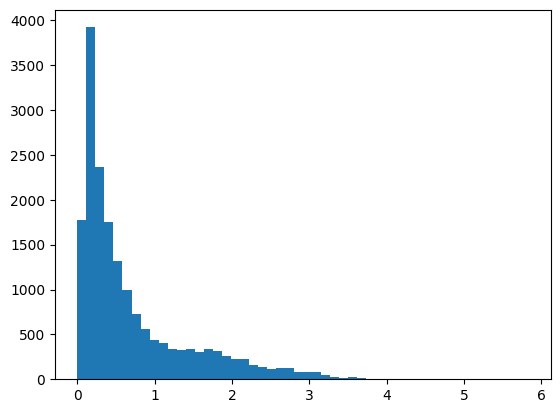

In [14]:
plt.hist(combined_tagged_units['sd'], bins=50)